In [46]:
from bs4 import BeautifulSoup
import csv
import json
from time import sleep
import pandas as pd
import requests
import warnings
warnings.filterwarnings('ignore')
warnings.warn("ignore")

In [24]:
baseUrl = 'https://www.pakwheels.com/used-cars/search/-/?page='
pageNo = 1

fullUrl = baseUrl + str(pageNo)
req = requests.get(fullUrl)
soup = BeautifulSoup(req.content)
carListings = soup.find_all("script", {"type": "application/ld+json"})

### Observation from page source
Each listing is preceded by a json description of the car features (search `application/ld+json` in the source). There are `n` items in the listings. The first one is the overall summary while the `n-1` are listing for each of car. (see `https://stackoverflow.com/questions/56008880/how-to-scrape-javascript-in-html-using-bs4-when-unrendered-no-selenium`)

We iterate through these listing and extract them into a json object which are already in dictionary format

In [25]:
carDict = dict()
for i in range(1,len(carListings)):
    carDict[i] = json.loads(carListings[i].contents[0])
print('Done')

Done


We quickly check that the carDict as well as its elements are actually dictionaries and convert them to dataframe.

In [36]:
print('Type of carDict and its first element are {} and {}'.format(type(carDict),type(carDict[9])))
df = pd.DataFrame(carDict).T  # we have transposed it. Check without transpose
df.head()

Type of carDict and its first element are <class 'dict'> and <class 'dict'>


,@context,@type,brand,description,itemCondition,modelDate,manufacturer,fuelType,name,image,vehicleTransmission,vehicleEngine,mileageFromOdometer,offers
1,https://schema.org,"[Product, Car]","{'@type': 'Brand', 'name': 'Audi'}",Audi Q7 2007 for sale in Mirpur A.K.,used,2007,Audi,Diesel,Audi Q7 2007 for sale in Mirpur A.K.,https://cache2.pakwheels.com/ad_pictures/4978/...,Automatic,"{'@type': 'EngineSpecification', 'engineDispla...","116,000 km","{'@context': 'https://schema.org', '@type': 'O..."
2,https://schema.org,"[Product, Car]","{'@type': 'Brand', 'name': 'Honda'}",Honda Vezel 2016 for sale in Lahore,used,2016,Honda,Hybrid,Honda Vezel 2016 for sale in Lahore,https://cache2.pakwheels.com/ad_pictures/6533/...,Automatic,"{'@type': 'EngineSpecification', 'engineDispla...","95,345 km","{'@context': 'https://schema.org', '@type': 'O..."
3,https://schema.org,"[Product, Car]","{'@type': 'Brand', 'name': 'Range Rover'}",Range Rover Autobiography 2018 for sale in Kar...,used,2018,Range Rover,Petrol,Range Rover Autobiography 2018 for sale in Kar...,https://cache1.pakwheels.com/ad_pictures/6532/...,Automatic,"{'@type': 'EngineSpecification', 'engineDispla...","20,000 km","{'@context': 'https://schema.org', '@type': 'O..."
4,https://schema.org,"[Product, Car]","{'@type': 'Brand', 'name': 'Toyota'}",Toyota Vitz 2019 for sale in Islamabad,used,2019,Toyota,Petrol,Toyota Vitz 2019 for sale in Islamabad,https://cache3.pakwheels.com/ad_pictures/6425/...,Automatic,"{'@type': 'EngineSpecification', 'engineDispla...","75,461 km","{'@context': 'https://schema.org', '@type': 'O..."
5,https://schema.org,"[Product, Car]","{'@type': 'Brand', 'name': 'Toyota'}",Toyota Corolla 2021 for sale in Lahore,used,2021,Toyota,Petrol,Toyota Corolla 2021 for sale in Lahore,https://cache1.pakwheels.com/ad_pictures/6532/...,Manual,"{'@type': 'EngineSpecification', 'engineDispla...","23,000 km","{'@context': 'https://schema.org', '@type': 'O..."


### Select related features
We select features of interest for further analysis

In [62]:
selDf = df[['manufacturer', 'description', 'itemCondition', 'modelDate', 
         'fuelType', 'vehicleTransmission', 'mileageFromOdometer']]
selDf.head()

,manufacturer,description,itemCondition,modelDate,fuelType,vehicleTransmission,mileageFromOdometer
1,Audi,Audi Q7 2007 for sale in Mirpur A.K.,used,2007,Diesel,Automatic,"116,000 km"
2,Honda,Honda Vezel 2016 for sale in Lahore,used,2016,Hybrid,Automatic,"95,345 km"
3,Range Rover,Range Rover Autobiography 2018 for sale in Kar...,used,2018,Petrol,Automatic,"20,000 km"
4,Toyota,Toyota Vitz 2019 for sale in Islamabad,used,2019,Petrol,Automatic,"75,461 km"
5,Toyota,Toyota Corolla 2021 for sale in Lahore,used,2021,Petrol,Manual,"23,000 km"


### Automate to scrape many pages (Should do all pages in the end)
We see that each page URL has a specific format. We use that in our for loop and iterate through multiple pages at once.

But first we create a function that will take URL as input and return dataframe of car info

In [63]:
def parsePakWheelSinglePage(url):
    req = requests.get(fullUrl)
    soup = BeautifulSoup(req.content)
    carListings = soup.find_all("script", {"type": "application/ld+json"})
    
    carDict = dict()
    for i in range(1,len(carListings)):
        carDict[i] = json.loads(carListings[i].contents[0])
    
    df = pd.DataFrame(carDict).T
    selDf = df[['manufacturer', 'description', 'itemCondition', 'modelDate', 
         'fuelType', 'vehicleTransmission', 'mileageFromOdometer']]
    return selDf

We quickly check above function to see it works. Let's check it for page 2 (feel free to check it for page 1 or any other page)

In [65]:
baseUrl = 'https://www.pakwheels.com/used-cars/search/-/?page='
pageNo = 2

fullUrl = baseUrl + str(pageNo)
curDf = parsePakWheelSinglePage(fullUrl)
curDf.head(n=3)

,manufacturer,description,itemCondition,modelDate,fuelType,vehicleTransmission,mileageFromOdometer
1,KIA,KIA Sportage 2021 for sale in Lahore,used,2021,Petrol,Automatic,"18,500 km"
2,Honda,Honda City 2013 for sale in Islamabad,used,2013,Petrol,Automatic,"295,000 km"
3,Range Rover,Range Rover Autobiography 2007 for sale in Lahore,used,2007,Petrol,Automatic,"122,000 km"


Now we automate the process for first 5 pages to save time. However, this should be done for ALL pages on PakWheels for full analysis

In [67]:
allData = pd.DataFrame()
baseUrl = 'https://www.pakwheels.com/used-cars/search/-/?page='
numPages = 5
for pageNo in range(1,numPages):
    print("processing page {}".format(pageNo))
    fullUrl = baseUrl + str(pageNo)
    curDf = parseOnePage(fullUrl)
    # now concatenate with outer dataframe
    allData = pd.concat([allData, curDf])
    # we wait for few seconds so as not to bombard server with too many requests
    sleep(3)
print('Done for {}'.format(numPages))
print('Total number of records are {} pages'.format(allData.shape[0]))


processing page 1
processing page 2
processing page 3
processing page 4
Done for 5
Total number of records are 106 pages


Now we can do this for ALL pages on PakWheels (click `Last >>` on PakWheels page to see how many pages are there)

Quickly go to end of page 5 in PakWheels to see that the last entry in your dataframe contains entry for the last car there (note it may be missed by 1 or few if there are cars added between your above script and when you check it)

In [50]:
allData.tail()

,manufacturer,description,itemCondition,modelDate,fuelType,vehicleTransmission,mileageFromOdometer
33,Suzuki,Suzuki Alto 2019 for sale in Lahore,used,2019,Petrol,Automatic,"20,000 km"
34,Toyota,Toyota Vitz 2018 for sale in Lahore,used,2018,Petrol,Automatic,"42,000 km"
35,KIA,KIA Sportage 2021 for sale in Sialkot,used,2021,Petrol,Automatic,"8,500 km"
36,Suzuki,Suzuki Cultus 2019 for sale in Lahore,used,2019,Petrol,Manual,"52,000 km"
37,Toyota,Toyota Corolla 2017 for sale in Mardan,used,2017,Petrol,Automatic,"71,560 km"


#### Some final formatting
We do the following 
1. Extract city name from description 
2. Remove extra string from description
3. Remove no-integer characters from `mileageFromOdometer` and change datatype to integer.
3. Rename description to modelYear

In [71]:
finalData = allData.copy()
finalData[['description', 'city']] = finalData['description'].str.split(' for sale in ', 1, expand=True)
# remove model year as we have it in separate column
finalData['description'] = finalData['description'].str.replace('\d{4}', '')
finalData['mileageFromOdometer'] = finalData['mileageFromOdometer'].str.replace(',|km','')
finalData['mileageFromOdometer'] = finalData['mileageFromOdometer'].astype(int)
finalData.rename(columns = {'description': 'modelName'}, inplace=True)
finalData.tail()

,manufacturer,modelName,itemCondition,modelDate,fuelType,vehicleTransmission,mileageFromOdometer,city
32,Toyota,Toyota Prado,used,2017,Petrol,Automatic,30500,Islamabad
33,Honda,Honda City,used,2021,Petrol,Automatic,8000,Lahore
34,Honda,Honda Civic,used,2022,Petrol,Automatic,40,Rawalpindi
35,Toyota,Toyota Corolla,used,2017,Petrol,Automatic,113000,Lahore
36,Toyota,Toyota Yaris,used,2021,Petrol,Automatic,7000,Lahore


##### Now the data is ready for analysis

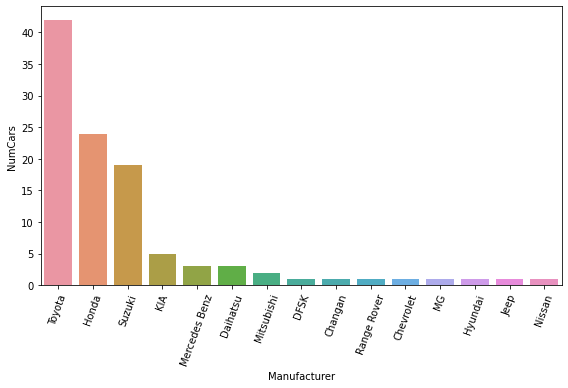

In [80]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,5.5)
import seaborn as sns
uniqMan = finalData['manufacturer'].value_counts().reset_index()
uniqMan.columns = ['Manufacturer','NumCars']
ax = sns.barplot(x='Manufacturer', y='NumCars', data=uniqMan)
plt.xticks(rotation=70)
plt.tight_layout()

--------